In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import colors
import seaborn
import geopandas as gpd
from libpysal import weights
from libpysal.weights.contiguity import Queen
import esda
from esda.moran import Moran_Local
import h3 as h3
from shapely.geometry import Polygon
import splot
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import lisa_cluster
import contextily

## Data inputs

In [2]:
# Read csv data
accident = pd.read_csv('dft-accident.csv')
vehicle = pd.read_csv('dft-vehicle.csv')
london_la = pd.read_csv('Local_Authority_District_to_County_(December_2015)_Lookup_in_England.csv')
label_lookup = pd.read_csv('Road-Safety-Open-Dataset-Data-Guide.csv')

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,2,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# filter for LAD15CD codes for London
london_la = london_la[london_la['CTY15NM'].str.contains('London')]
london_la.head()

,LAD15CD,LAD15CDO,LAD15NM,CTY15CD,CTY15CDO,CTY15NM,FID
0,E09000001,00AA,City of London,E13000001,0,Inner London,1
2,E09000002,00AB,Barking and Dagenham,E13000002,0,Outer London,3
5,E09000003,00AC,Barnet,E13000002,0,Outer London,6
6,E09000004,00AD,Bexley,E13000002,0,Outer London,7
9,E09000005,00AE,Brent,E13000002,0,Outer London,10


In [4]:
accident_london = accident[accident['local_authority_ons_district'].isin(london_la['LAD15CD'])]
accident_london

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,5,1,1,1,0,0,1,3,2,E01004762
1,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,9,4,1,1,0,0,1,3,2,E01003117
2,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,4,1,1,0,0,1,1,2,E01000943
3,2019010155192,2019,10155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,...,0,4,1,1,0,0,1,1,2,E01000973
4,2019010155194,2019,10155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,...,0,4,1,1,0,0,1,1,2,E01000546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97737,2019480951145,2019,480951145,532815.0,181184.0,-0.087348,51.513978,48,3,1,...,0,4,1,1,0,0,1,2,2,E01032739
97738,2019480951151,2019,480951151,533246.0,181528.0,-0.081010,51.516968,48,3,1,...,5,1,1,1,0,0,1,2,2,E01032739
97739,2019480951155,2019,480951155,531454.0,180831.0,-0.107082,51.511124,48,3,2,...,0,4,1,1,0,0,1,2,2,E01032740
97740,2019480951177,2019,480951177,532251.0,181025.0,-0.095531,51.512682,48,3,2,...,5,1,2,2,0,0,1,1,2,E01032739


In [5]:
accident_london.to_csv('london_accidents.csv')

In [6]:
list(accident_london.columns.values)

['accident_index',
 'accident_year',
 'accident_reference',
 'location_easting_osgr',
 'location_northing_osgr',
 'longitude',
 'latitude',
 'police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'local_authority_ons_district',
 'local_authority_highway',
 'first_road_class',
 'first_road_number',
 'road_type',
 'speed_limit',
 'junction_detail',
 'junction_control',
 'second_road_class',
 'second_road_number',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident',
 'trunk_road_flag',
 'lsoa_of_accident_location']

In [7]:
accident_london.dtypes

accident_index                                  object
accident_year                                    int64
accident_reference                              object
location_easting_osgr                          float64
location_northing_osgr                         float64
longitude                                      float64
latitude                                       float64
police_force                                     int64
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
date                                            object
day_of_week                                      int64
time                                            object
local_authority_district                         int64
local_authority_ons_district                    object
local_authority_highway                         object
first_road_class                                 int64
first_road

In [8]:
date = accident_london['date'].str.split('/', expand=True)
accident_london['day'] = date[0]
accident_london['month'] = date[1]

time = accident_london['time'].str.split(':', expand=True)
accident_london['hour'] = time[0]
accident_london['minute'] = time[1]

accident_london

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,day,month,hour,minute
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,0,1,3,2,E01004762,18,02,17,50
1,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,0,0,1,3,2,E01003117,15,01,21,45
2,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,0,1,1,2,E01000943,01,01,01,50
3,2019010155192,2019,10155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,...,0,0,1,1,2,E01000973,01,01,01,20
4,2019010155194,2019,10155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,...,0,0,1,1,2,E01000546,01,01,00,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97737,2019480951145,2019,480951145,532815.0,181184.0,-0.087348,51.513978,48,3,1,...,0,0,1,2,2,E01032739,17,10,22,15
97738,2019480951151,2019,480951151,533246.0,181528.0,-0.081010,51.516968,48,3,1,...,0,0,1,2,2,E01032739,24,10,18,10
97739,2019480951155,2019,480951155,531454.0,180831.0,-0.107082,51.511124,48,3,2,...,0,0,1,2,2,E01032740,06,12,18,30
97740,2019480951177,2019,480951177,532251.0,181025.0,-0.095531,51.512682,48,3,2,...,0,0,1,1,2,E01032739,12,12,15,23


In [9]:
weekday = [1,2,3,4,5]
weekend = [6,7]

weekday_accidents = accident_london[accident_london['day_of_week'].isin(weekday)]
weekday_accidents = weekday_accidents.sort_values('hour', ascending=True)

weekend_accidents = accident_london[accident_london['day_of_week'].isin(weekend)]
weekend_accidents = weekend_accidents.sort_values('hour', ascending=True)

[Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Weekend Accidents')]

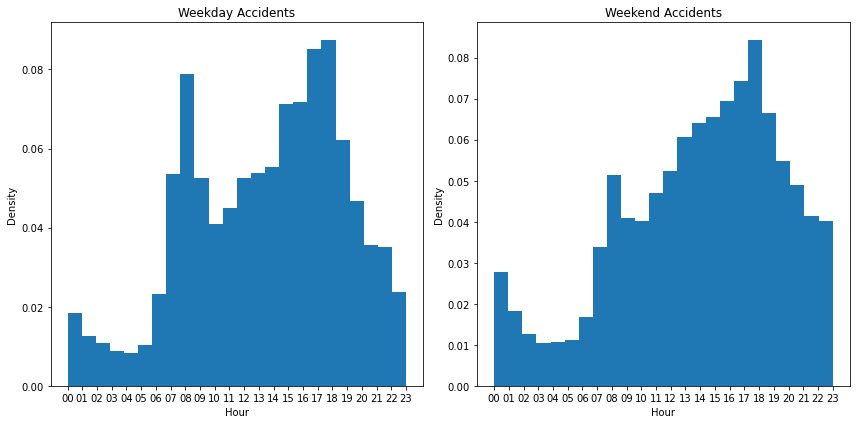

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), tight_layout=True)

axs[0].hist(weekday_accidents['hour'], bins=24, density=True)
axs[1].hist(weekend_accidents['hour'], bins=24, density=True)
axs[0].set(xlabel="Hour", ylabel="Density", title="Weekday Accidents")
axs[1].set(xlabel="Hour", ylabel="Density", title="Weekend Accidents")

In [11]:
accident_london['date'] = pd.to_datetime(accident_london['date'])
accident_london

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,day,month,hour,minute
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,0,1,3,2,E01004762,18,02,17,50
1,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,0,0,1,3,2,E01003117,15,01,21,45
2,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,0,1,1,2,E01000943,01,01,01,50
3,2019010155192,2019,10155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,...,0,0,1,1,2,E01000973,01,01,01,20
4,2019010155194,2019,10155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,...,0,0,1,1,2,E01000546,01,01,00,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97737,2019480951145,2019,480951145,532815.0,181184.0,-0.087348,51.513978,48,3,1,...,0,0,1,2,2,E01032739,17,10,22,15
97738,2019480951151,2019,480951151,533246.0,181528.0,-0.081010,51.516968,48,3,1,...,0,0,1,2,2,E01032739,24,10,18,10
97739,2019480951155,2019,480951155,531454.0,180831.0,-0.107082,51.511124,48,3,2,...,0,0,1,2,2,E01032740,06,12,18,30
97740,2019480951177,2019,480951177,532251.0,181025.0,-0.095531,51.512682,48,3,2,...,0,0,1,1,2,E01032739,12,12,15,23


In [12]:
daily_count = accident_london.groupby('date').size()
daily_count = daily_count.to_frame()
daily_count.reset_index(inplace=True)
daily_count['moving_average'] = daily_count[0].rolling(7).mean()
daily_count

,date,0,moving_average
0,2019-01-01,49,NaN
1,2019-01-02,77,NaN
2,2019-01-03,56,NaN
3,2019-01-04,84,NaN
4,2019-01-05,73,NaN
...,...,...,...
360,2019-12-27,37,44.857143
361,2019-12-28,42,41.857143
362,2019-12-29,45,41.857143
363,2019-12-30,43,38.285714


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Count of Accidents'),
 Text(0.5, 1.0, 'Temporal analysis of accident counts')]

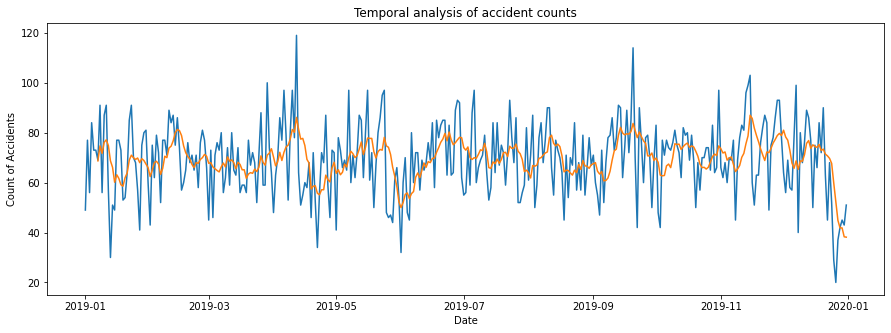

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(15,5) )
#plt.figure(figsize=(15,5))
#axes.xaxis.set_major_locator(MaxNLocator(nbins=12, min_n_ticks=12))
axes.plot(daily_count['date'], daily_count[0])
axes.plot(daily_count['date'], daily_count['moving_average'])
axes.set(xlabel="Date", ylabel="Count of Accidents", title="Temporal analysis of accident counts")

## Weather conditions

In [14]:
weather  = label_lookup[label_lookup['field name'].str.contains('weather_conditions')]
weather

,table,field name,code/format,label,note
1185,Accident,weather_conditions,1,Fine no high winds,NaN
1186,Accident,weather_conditions,2,Raining no high winds,NaN
1187,Accident,weather_conditions,3,Snowing no high winds,NaN
1188,Accident,weather_conditions,4,Fine + high winds,NaN
1189,Accident,weather_conditions,5,Raining + high winds,NaN
1190,Accident,weather_conditions,6,Snowing + high winds,NaN
1191,Accident,weather_conditions,7,Fog or mist,NaN
1192,Accident,weather_conditions,8,Other,NaN
1193,Accident,weather_conditions,9,Unknown,NaN
1194,Accident,weather_conditions,-1,Data missing or out of range,NaN


In [15]:
accident_london.loc[accident_london['weather_conditions']==1,'weather_conditions'] = "Low precipitation day"
accident_london.loc[accident_london['weather_conditions']==2,'weather_conditions'] = "High precipitation day"
accident_london.loc[accident_london['weather_conditions']==3,'weather_conditions'] = "High precipitation day"
accident_london.loc[accident_london['weather_conditions']==4,'weather_conditions'] = "Low precipitation day"
accident_london.loc[accident_london['weather_conditions']==5,'weather_conditions'] = "High precipitation day"
accident_london.loc[accident_london['weather_conditions']==6,'weather_conditions'] = "High precipitation day"
accident_london.loc[accident_london['weather_conditions']==7,'weather_conditions'] = "High precipitation day"
accident_london.loc[accident_london['weather_conditions']==8,'weather_conditions'] = "Other"
accident_london.loc[accident_london['weather_conditions']==9,'weather_conditions'] = "Other"
accident_london.loc[accident_london['weather_conditions']==-1,'weather_conditions'] = "Other"

daily_count_weather = accident_london.groupby(["date","weather_conditions"]).size()
daily_count_weather = daily_count_weather.to_frame()
daily_count_weather.reset_index(inplace=True)

daily_count_weather

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,date,weather_conditions,0
0,2019-01-01,Low precipitation day,47
1,2019-01-01,Other,2
2,2019-01-02,High precipitation day,71
3,2019-01-02,Low precipitation day,2
4,2019-01-02,Other,4
...,...,...,...
974,2019-12-30,Low precipitation day,38
975,2019-12-30,Other,4
976,2019-12-31,High precipitation day,8
977,2019-12-31,Low precipitation day,34


[Text(0.5, 0, 'Number of accidents'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Impact of Weather Conditions')]

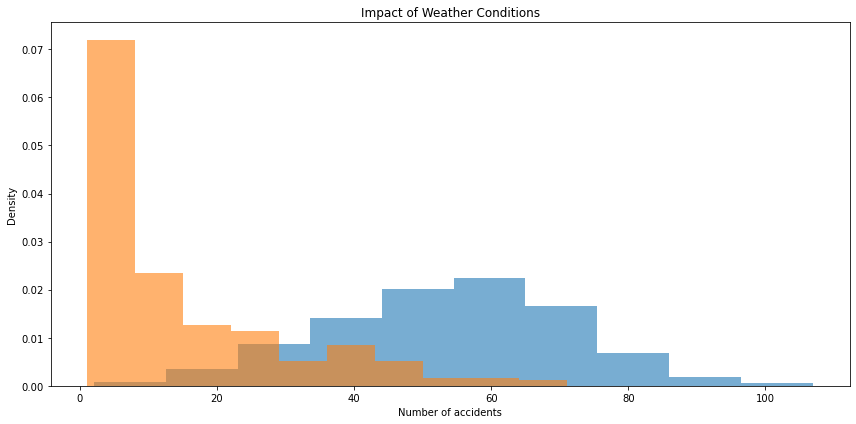

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(12,6), tight_layout=True)

low_precip = daily_count_weather[daily_count_weather['weather_conditions'].str.contains('Low', regex=False)]
high_precip = daily_count_weather[daily_count_weather['weather_conditions'].str.contains('High', regex=False)]
other_precip = daily_count_weather[daily_count_weather['weather_conditions'].str.contains('Other', regex=False)]

axs.hist(low_precip[0], density=True, bins=10, alpha=0.6)
axs.hist(high_precip[0], density=True, bins=10, alpha=0.6)
#axs.hist(other_precip[0],density=True, bins=10, alpha=0.6)

axs.set(xlabel="Number of accidents", ylabel="Density", title="Impact of Weather Conditions")

## Road surface conditions

In [17]:
accident_london.loc[accident_london['road_surface_conditions']==1,'road_surface_conditions'] = "Dry"
accident_london.loc[accident_london['road_surface_conditions']==2,'road_surface_conditions'] = "Wet"
accident_london.loc[accident_london['road_surface_conditions']==3,'road_surface_conditions'] = "Wet"
accident_london.loc[accident_london['road_surface_conditions']==4,'road_surface_conditions'] = "Wet"
accident_london.loc[accident_london['road_surface_conditions']==5,'road_surface_conditions'] = "Wet"
accident_london.loc[accident_london['road_surface_conditions']==6,'road_surface_conditions'] = "Wet"
accident_london.loc[accident_london['road_surface_conditions']==7,'road_surface_conditions'] = "Wet"
accident_london.loc[accident_london['road_surface_conditions']==-1,'road_surface_conditions'] = "Other"
accident_london.loc[accident_london['road_surface_conditions']==9,'road_surface_conditions'] = "Other"

daily_count_surface = accident_london.groupby(["date","road_surface_conditions"]).size()
daily_count_surface = daily_count_surface.to_frame()
daily_count_surface.reset_index(inplace=True)

daily_count_surface

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,date,road_surface_conditions,0
0,2019-01-01,Dry,48
1,2019-01-01,Wet,1
2,2019-01-02,Dry,3
3,2019-01-02,Other,1
4,2019-01-02,Wet,73
...,...,...,...
989,2019-12-30,Other,3
990,2019-12-30,Wet,8
991,2019-12-31,Dry,27
992,2019-12-31,Other,8


[Text(0.5, 0, 'Number of accidents'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Impact of Road Surface Conditions')]

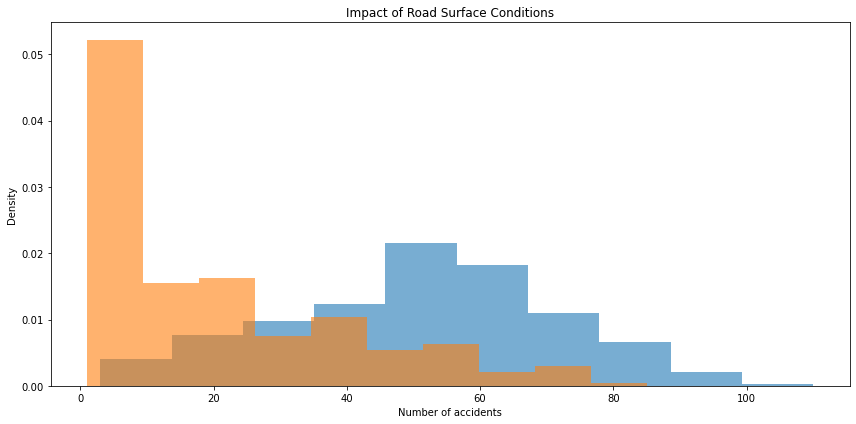

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12,6), tight_layout=True)

dry_surface = daily_count_surface[daily_count_surface['road_surface_conditions'].str.contains('Dry', regex=False)]
wet_surface = daily_count_surface[daily_count_surface['road_surface_conditions'].str.contains('Wet', regex=False)]
oth_surface = daily_count_surface[daily_count_surface['road_surface_conditions'].str.contains('Other', regex=False)]

axs.hist(dry_surface[0], density=True, bins=10, alpha=0.6)
axs.hist(wet_surface[0], density=True, bins=10, alpha=0.6)
#axs.hist(oth_surface[0],density=True, bins=10, alpha=0.6)

axs.set(xlabel="Number of accidents", ylabel="Density", title="Impact of Road Surface Conditions")

## H3 aggregation

In [19]:
acc_lon_gdf = gpd.GeoDataFrame(accident_london, geometry=gpd.points_from_xy(accident_london.longitude, accident_london.latitude))
acc_lon_gdf.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,day,month,hour,minute,geometry
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,1,3,2,E01004762,18,02,17,50,POINT (-0.15384 51.50806)
1,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,0,1,3,2,E01003117,15,01,21,45,POINT (-0.12795 51.43621)
2,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,1,1,2,E01000943,01,01,01,50,POINT (-0.12419 51.52679)
3,2019010155192,2019,10155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,...,0,1,1,2,E01000973,01,01,01,20,POINT (-0.19104 51.54639)
4,2019010155194,2019,10155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,...,0,1,1,2,E01000546,01,01,00,40,POINT (-0.20006 51.54112)


In [20]:
h3_level = 8

def lat_lng_to_h3(row):
    return h3.geo_to_h3(row.geometry.y, row.geometry.x, h3_level)

def add_geometry(row):
    points = h3.h3_to_geo_boundary(row['h3'], True)
    return Polygon(points)

acc_lon_gdf['h3'] = acc_lon_gdf.apply(lat_lng_to_h3, axis=1)
counts = acc_lon_gdf.groupby(['h3']).h3.agg('count').to_frame('count').reset_index()
counts['geometry'] = counts.apply(add_geometry, axis=1)
gdf = gpd.GeoDataFrame(counts, crs='EPSG:4326')

In [21]:
gdf

,h3,count,geometry
0,88194ac001fffff,6,"POLYGON ((-0.12807 51.32911, -0.13476 51.32791..."
1,88194ac003fffff,1,"POLYGON ((-0.12382 51.32134, -0.13051 51.32014..."
2,88194ac007fffff,10,"POLYGON ((-0.13598 51.32342, -0.14266 51.32222..."
3,88194ac009fffff,9,"POLYGON ((-0.12016 51.33479, -0.12685 51.33359..."
4,88194ac00bfffff,1,"POLYGON ((-0.11592 51.32702, -0.12260 51.32582..."
...,...,...,...
2067,88195db6b1fffff,23,"POLYGON ((-0.03661 51.68577, -0.04333 51.68459..."
2068,88195db6b3fffff,10,"POLYGON ((-0.03235 51.67802, -0.03907 51.67684..."
2069,88195db6b5fffff,29,"POLYGON ((-0.04883 51.68787, -0.05555 51.68669..."
2070,88195db6b7fffff,2,"POLYGON ((-0.04457 51.68013, -0.05129 51.67894..."


In [22]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

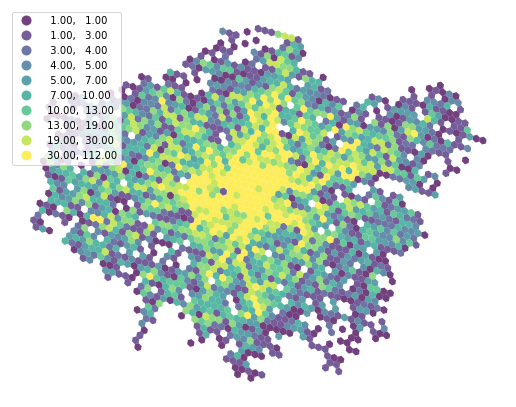

In [23]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='count', 
        cmap='viridis', 
        scheme='quantiles',
        k=10, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

## Local Moran I

In [24]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gdf, k=18)
# Row-standardization
w.transform = 'R'

In [25]:
y = gdf['count'].values

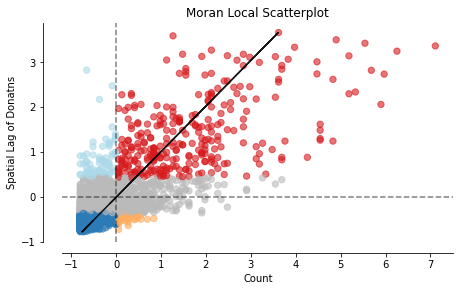

In [26]:
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05, zstandard=True)
ax.set_xlabel('Count')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

In [27]:
(moran_loc.p_sim < 0.05).sum()

1123

## Cluster visualisation plot
lisa_cluster function plot in a skewed projection, as shown in the first code block below. So we can manually assign colours to the colors based on their significance of the Local Moran analysis, which then can be plotted correctly.

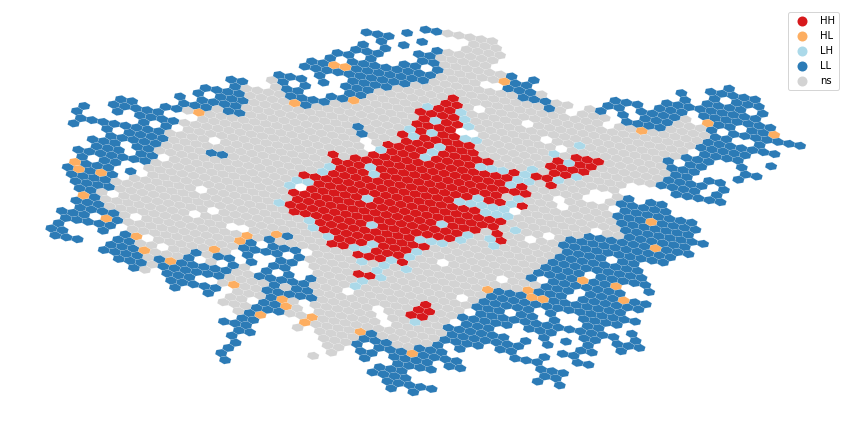

In [28]:
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (15,15))
plt.show()

In [29]:
sig = 1 * (moran_loc.p_sim < 0.05)
hotspot = 1 * (sig * moran_loc.q==1)
coldspot = 3 * (sig * moran_loc.q==3)
doughnut = 2 * (sig * moran_loc.q==2)
diamond = 4 * (sig * moran_loc.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, ..., 0, 0, 0])

In [30]:
spot_labels = [ 'Not significant', 'High-High', 'Low-High', 'Low-Low', 'High-Low']
labels = [spot_labels[i] for i in spots]

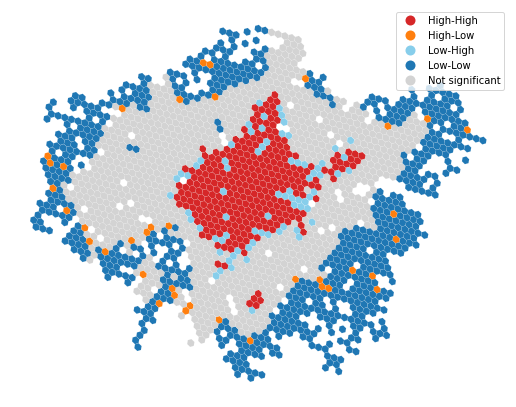

In [31]:
hmap = colors.ListedColormap([ 'tab:red', 'tab:orange', 'skyblue', 'tab:blue', 'lightgray'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

## Get Dummies

In [32]:
vehicle = vehicle[["accident_index","age_band_of_driver","vehicle_type"]]
acc_lon_gdf_veh = pd.merge(acc_lon_gdf, vehicle, left_on='accident_index', right_on='accident_index', how='left')
acc_lon_gdf_veh.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,trunk_road_flag,lsoa_of_accident_location,day,month,hour,minute,geometry,h3,age_band_of_driver,vehicle_type
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,2,E01004762,18,02,17,50,POINT (-0.15384 51.50806),88195da495fffff,9.0,9.0
1,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,2,E01004762,18,02,17,50,POINT (-0.15384 51.50806),88195da495fffff,-1.0,9.0
2,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,2,E01003117,15,01,21,45,POINT (-0.12795 51.43621),88194ad1e1fffff,5.0,9.0
3,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,2,E01003117,15,01,21,45,POINT (-0.12795 51.43621),88194ad1e1fffff,-1.0,9.0
4,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,2,E01000943,01,01,01,50,POINT (-0.12419 51.52679),88195da4dbfffff,7.0,9.0


In [33]:
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==1,'age_band_of_driver'] = "0-5"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==2,'age_band_of_driver'] = "6-10"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==3,'age_band_of_driver'] = "11-15"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==4,'age_band_of_driver'] = "16-20"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==5,'age_band_of_driver'] = "21-25"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==6,'age_band_of_driver'] = "26-35"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==7,'age_band_of_driver'] = "36-45"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==8,'age_band_of_driver'] = "46-55"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==9,'age_band_of_driver'] = "56-65"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==10,'age_band_of_driver'] = "66-75"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==11,'age_band_of_driver'] = "Over 75"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['age_band_of_driver']==-1,'age_band_of_driver'] = "None"

In [34]:
acc_lon_gdf_veh['age_band_of_driver'] = acc_lon_gdf_veh['age_band_of_driver'].astype(str)
age = acc_lon_gdf_veh['age_band_of_driver'].str.get_dummies()
age = age.drop(age.columns[[0, 1, 10, 12]], axis=1)
acc_lon_gdf_veh = acc_lon_gdf_veh.merge(age, left_index=True, right_index=True)
acc_lon_gdf_veh

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,vehicle_type,16-20,21-25,26-35,36-45,46-55,56-65,6-10,66-75,Over 75
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,9.0,0,0,0,0,0,1,0,0,0
1,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,9.0,0,0,0,0,0,0,0,0,0
2,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,9.0,0,1,0,0,0,0,0,0,0
3,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,9.0,0,0,0,0,0,0,0,0,0
4,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,9.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44117,2019480951145,2019,480951145,532815.0,181184.0,-0.087348,51.513978,48,3,1,...,NaN,0,0,0,0,0,0,0,0,0
44118,2019480951151,2019,480951151,533246.0,181528.0,-0.081010,51.516968,48,3,1,...,NaN,0,0,0,0,0,0,0,0,0
44119,2019480951155,2019,480951155,531454.0,180831.0,-0.107082,51.511124,48,3,2,...,NaN,0,0,0,0,0,0,0,0,0
44120,2019480951177,2019,480951177,532251.0,181025.0,-0.095531,51.512682,48,3,2,...,NaN,0,0,0,0,0,0,0,0,0


In [35]:
age_group = acc_lon_gdf_veh.groupby(['h3'])['66-75','Over 75','16-20','21-25','26-35','36-45','46-55','56-65'].agg('sum')

moran_class = pd.DataFrame({'class':labels})

age_group = age_group.reset_index()
age_group = age_group.merge(moran_class, left_index=True, right_index=True)
age_group

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,h3,66-75,Over 75,16-20,21-25,26-35,36-45,46-55,56-65,class
0,88194ac001fffff,0,0,1,1,3,1,1,0,Low-Low
1,88194ac003fffff,0,1,0,0,0,0,1,0,Low-Low
2,88194ac007fffff,1,0,1,1,4,4,2,1,Low-Low
3,88194ac009fffff,1,0,1,1,2,2,1,1,Low-Low
4,88194ac00bfffff,0,0,0,0,0,2,0,0,Low-Low
...,...,...,...,...,...,...,...,...,...,...
2067,88195db6b1fffff,2,0,1,7,4,9,7,3,Not significant
2068,88195db6b3fffff,1,0,1,1,2,1,2,1,Not significant
2069,88195db6b5fffff,2,1,4,6,15,11,8,5,Not significant
2070,88195db6b7fffff,1,0,0,0,0,0,0,0,Not significant


In [36]:
HL = age_group[age_group['class'].str.contains('High-Low')]

age_comparison = HL.sum(axis=0)
age_comparison = age_comparison.to_frame().transpose()
age_comparison.drop(['class'],axis=1, inplace=True)
age_comparison.at[0,'h3']= 'HL'

all_age = age_group.sum(axis=0)
all_age = all_age.to_frame().transpose()
all_age.drop(['class'],axis=1, inplace=True)
all_age.at[0,'h3']= 'All'
all_age

age_comparison = age_comparison.append(all_age, ignore_index=True)
age_comparison = age_comparison.transpose()
age_comparison = age_comparison.rename(columns=age_comparison.iloc[0]).drop(age_comparison.index[0])

age_comparison = age_comparison/age_comparison.sum()
age_comparison = age_comparison.transpose()

age_comparison

,66-75,Over 75,16-20,21-25,26-35,36-45,46-55,56-65
HL,0.039953,0.021152,0.07168,0.113984,0.26087,0.225617,0.175088,0.091657
All,0.027442,0.013276,0.056452,0.117483,0.29618,0.230847,0.170708,0.087613


In [37]:
age_comparison = age_comparison[['16-20','21-25','26-35','36-45','46-55','56-65','66-75','Over 75']]
age_comparison

,16-20,21-25,26-35,36-45,46-55,56-65,66-75,Over 75
HL,0.07168,0.113984,0.26087,0.225617,0.175088,0.091657,0.039953,0.021152
All,0.056452,0.117483,0.29618,0.230847,0.170708,0.087613,0.027442,0.013276


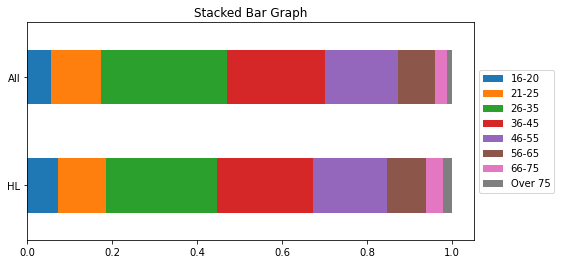

In [38]:
age_comparison.plot(kind = 'barh', stacked=True, title = 'Stacked Bar Graph', figsize=(8,4))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Day of the week

In [39]:
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==1,'day_of_week'] = "Weekday"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==2,'day_of_week'] = "Weekday"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==3,'day_of_week'] = "Weekday"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==4,'day_of_week'] = "Weekday"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==5,'day_of_week'] = "Weekday"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==6,'day_of_week'] = "Weekend"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['day_of_week']==7,'day_of_week'] = "Weekend"

In [40]:
acc_lon_gdf_veh['day_of_week'] = acc_lon_gdf_veh['day_of_week'].astype(str)
day = acc_lon_gdf_veh['day_of_week'].str.get_dummies()
acc_lon_gdf_veh = acc_lon_gdf_veh.merge(day, left_index=True, right_index=True)
acc_lon_gdf_veh

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,21-25,26-35,36-45,46-55,56-65,6-10,66-75,Over 75,Weekday,Weekend
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,0,0,0,1,0,0,0,1,0
1,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,0,0,0,0,0,0,0,1,0
2,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,1,0,0,0,0,0,0,0,1,0
3,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,0,0,0,0,0,0,0,0,1,0
4,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44117,2019480951145,2019,480951145,532815.0,181184.0,-0.087348,51.513978,48,3,1,...,0,0,0,0,0,0,0,0,1,0
44118,2019480951151,2019,480951151,533246.0,181528.0,-0.081010,51.516968,48,3,1,...,0,0,0,0,0,0,0,0,1,0
44119,2019480951155,2019,480951155,531454.0,180831.0,-0.107082,51.511124,48,3,2,...,0,0,0,0,0,0,0,0,0,1
44120,2019480951177,2019,480951177,532251.0,181025.0,-0.095531,51.512682,48,3,2,...,0,0,0,0,0,0,0,0,1,0


In [41]:
day_group = acc_lon_gdf_veh.groupby(['h3'])['Weekday','Weekend'].agg('sum')

moran_class = pd.DataFrame({'class':labels})

day_group = day_group.reset_index()
day_group = day_group.merge(moran_class, left_index=True, right_index=True)
day_group

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,h3,Weekday,Weekend,class
0,88194ac001fffff,8,1,Low-Low
1,88194ac003fffff,2,0,Low-Low
2,88194ac007fffff,13,7,Low-Low
3,88194ac009fffff,7,5,Low-Low
4,88194ac00bfffff,2,0,Low-Low
...,...,...,...,...
2067,88195db6b1fffff,42,4,Not significant
2068,88195db6b3fffff,12,4,Not significant
2069,88195db6b5fffff,49,13,Not significant
2070,88195db6b7fffff,1,2,Not significant


In [42]:
HL = day_group[day_group['class'].str.contains('High-Low')]

day_comparison = HL.sum(axis=0)
day_comparison = day_comparison.to_frame()
day_comparison = day_comparison.transpose()
day_comparison.drop(['class'],axis=1, inplace=True)
day_comparison.at[0,'h3']= 'HL'

all_day = day_group.sum(axis=0)
all_day = all_day.to_frame()
all_day = all_day.transpose()
all_day.drop(['class'],axis=1, inplace=True)
all_day.at[0,'h3']= 'All'
all_day

day_comparison = day_comparison.append(all_day, ignore_index=True)
day_comparison = day_comparison.transpose()
day_comparison = day_comparison.rename(columns=day_comparison.iloc[0]).drop(day_comparison.index[0])

day_comparison = day_comparison/day_comparison.sum()
day_comparison = day_comparison.transpose()

day_comparison

,Weekday,Weekend
HL,0.694572,0.305428
All,0.704909,0.295091


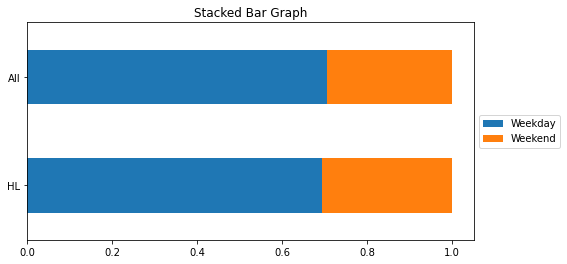

In [43]:
day_comparison.plot(kind = 'barh', stacked=True, title = 'Stacked Bar Graph', figsize=(8,4))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Vehicle Type

In [44]:
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==1,'vehicle_type'] = "Pedal Cycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==2,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==3,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==4,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==5,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==8,'vehicle_type'] = "Taxi"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==9,'vehicle_type'] = "Car"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==10,'vehicle_type'] = "Minibus"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==11,'vehicle_type'] = "Bus"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==16,'vehicle_type'] = "Horse"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==17,'vehicle_type'] = "Agricultural Vehicle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==18,'vehicle_type'] = "Tram"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==19,'vehicle_type'] = "Van"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==20,'vehicle_type'] = "Truck"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==21,'vehicle_type'] = "Truck"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==22,'vehicle_type'] = "Mobility Scooter"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==23,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==90,'vehicle_type'] = "Other"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==97,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==98,'vehicle_type'] = "Truck"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==99,'vehicle_type'] = "Other"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==103,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==104,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==105,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==106,'vehicle_type'] = "Motorcycle"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==108,'vehicle_type'] = "Taxi"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==109,'vehicle_type'] = "Car"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==110,'vehicle_type'] = "Minibus"
acc_lon_gdf_veh.loc[acc_lon_gdf_veh['vehicle_type']==113,'vehicle_type'] = "Truck"

In [45]:
acc_lon_gdf_veh['vehicle_type'] = acc_lon_gdf_veh['vehicle_type'].astype(str)
vehicle = acc_lon_gdf_veh['vehicle_type'].str.get_dummies()
acc_lon_gdf_veh = acc_lon_gdf_veh.merge(vehicle, left_index=True, right_index=True)
acc_lon_gdf_veh

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,Minibus,Mobility Scooter,Motorcycle,Other,Pedal Cycle,Taxi,Tram,Truck,Van,nan
0,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,0,0,0,0,0,0,0,0,0
1,2019010128300,2019,10128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,...,0,0,0,0,0,0,0,0,0,0
2,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,0,0,0,0,0,0,0,0,0,0
3,2019010152270,2019,10152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,...,0,0,0,0,0,0,0,0,0,0
4,2019010155191,2019,10155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44117,2019480951145,2019,480951145,532815.0,181184.0,-0.087348,51.513978,48,3,1,...,0,0,0,0,0,0,0,0,0,1
44118,2019480951151,2019,480951151,533246.0,181528.0,-0.081010,51.516968,48,3,1,...,0,0,0,0,0,0,0,0,0,1
44119,2019480951155,2019,480951155,531454.0,180831.0,-0.107082,51.511124,48,3,2,...,0,0,0,0,0,0,0,0,0,1
44120,2019480951177,2019,480951177,532251.0,181025.0,-0.095531,51.512682,48,3,2,...,0,0,0,0,0,0,0,0,0,1


In [46]:
veh_group = acc_lon_gdf_veh.groupby(['h3'])['Pedal Cycle','Motorcycle','Taxi','Car','Minibus','Bus','Horse','Agricultural Vehicle','Tram','Van','Truck','Other'].agg('sum')

moran_class = pd.DataFrame({'class':labels})

veh_group = veh_group.reset_index()
veh_group = veh_group.merge(moran_class, left_index=True, right_index=True)
veh_group

/opt/miniconda3/envs/lon_acc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,h3,Pedal Cycle,Motorcycle,Taxi,Car,Minibus,Bus,Horse,Agricultural Vehicle,Tram,Van,Truck,Other,class
0,88194ac001fffff,0,0,0,7,1,0,0,0,0,1,0,0,Low-Low
1,88194ac003fffff,0,0,0,1,0,1,0,0,0,0,0,0,Low-Low
2,88194ac007fffff,1,0,1,16,0,0,0,0,0,1,1,0,Low-Low
3,88194ac009fffff,2,0,0,7,0,0,0,0,0,0,1,0,Low-Low
4,88194ac00bfffff,1,0,0,1,0,0,0,0,0,0,0,0,Low-Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,88195db6b1fffff,1,2,0,32,0,2,0,0,0,3,4,0,Not significant
2068,88195db6b3fffff,0,3,0,11,0,0,0,0,0,0,0,0,Not significant
2069,88195db6b5fffff,1,4,1,44,0,0,0,0,0,7,3,0,Not significant
2070,88195db6b7fffff,0,0,0,3,0,0,0,0,0,0,0,0,Not significant


In [49]:
HL = veh_group[veh_group['class'].str.contains('High-Low')]

veh_comparison = HL.sum(axis=0)
veh_comparison = veh_comparison.to_frame()
veh_comparison = veh_comparison.transpose()
veh_comparison.drop(['class'],axis=1, inplace=True)
veh_comparison.at[0,'h3']= 'HL'

all_veh = veh_group.sum(axis=0)
all_veh = all_veh.to_frame()
all_veh = all_veh.transpose()
all_veh.drop(['class'],axis=1, inplace=True)
all_veh.at[0,'h3']= 'All'
all_veh

veh_comparison = veh_comparison.append(all_veh, ignore_index=True)
veh_comparison = veh_comparison.transpose()
veh_comparison = veh_comparison.rename(columns=veh_comparison.iloc[0]).drop(veh_comparison.index[0])

veh_comparison = veh_comparison/veh_comparison.sum()
veh_comparison = veh_comparison.transpose()

veh_comparison

,Pedal Cycle,Motorcycle,Taxi,Car,Minibus,Bus,Horse,Agricultural Vehicle,Tram,Van,Truck,Other
HL,0.064885,0.100191,0.024809,0.697519,0.001908,0.037214,0.0,0.000954,0.0,0.064885,0.004771,0.002863
All,0.104362,0.134508,0.045516,0.599393,0.002372,0.033704,0.000095,0.000356,0.000024,0.062522,0.013543,0.003605


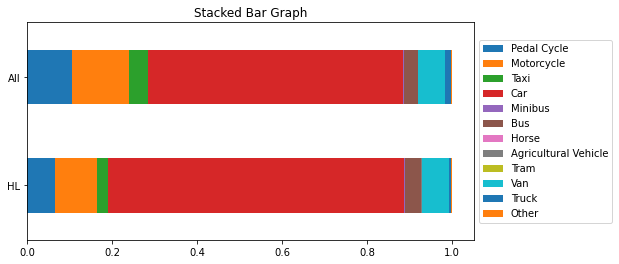

In [50]:
veh_comparison.plot(kind = 'barh', stacked=True, title = 'Stacked Bar Graph', figsize=(8,4))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))